# Case Study: miscalibration

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

plt.rcParams.update({
    'font.size': 8,
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
})

In [2]:
def create_relative_change_df(calibrated_data, noncal_data):
    df = pd.DataFrame(index=noncal_data.index, columns=noncal_data.columns)
    for col in df.columns:
        if col == 'PICP':
            df[col] = (abs(calibrated_data[col] - 0.95) - abs(noncal_data[col] - 0.95)) * 100
        else:
            df[col] = ((calibrated_data[col] - noncal_data[col]) / abs(noncal_data[col]) * 100)
    return df

In [3]:
data = pd.read_excel(os.path.join(os.getcwd(), 'results','miscalibration1', 'metrics_.xlsx'), index_col=0)
data = data[~data["name"].str.contains("noise_0_0")]

new_column_names = {
    'rmse': 'RMSE',
    'sharpness_std': 'Sharpness',
    'nll': 'NLL',
    'crps': 'CRPS',
    'interval': 'IS',
    'pinball': 'Pinball',
    'cal_score': 'CalS',
    'ecpe': 'ECPE',
    'qce': 'QCE',
    'picp': 'PICP',
    'cwc': 'CWC',
    'ence': 'ENCE',
    'uce': 'UCE'
}

new_data_names = {
    'forest_fires': '1',
    'facebook_metrics': '2',
    'computer_hardware': '3',
    'abalone': '4',
    'winequality': '5',
    'airfoil_self_noise': '6',
    'superconductivity_data': '7',
    'grid_stability': '8',
    'servo': '9',
    'concrete_compressive_strength': '10',
    'steel_industry': '11',
    'combined_cycle_power_plant': '12',
    'parkinson': '13',
    'auction_verification': '14',
    'energy_efficiency': '15',
    'age_prediction': '16'
}

data.rename(columns=new_column_names, inplace=True)
data['name'] = data['name'].map(new_data_names).fillna(data['name']).astype(str)

metrics = list(new_column_names.values())

df = data[data['n_run'] == 0]
df = df[list(new_column_names.values()) + ['name', 'calibration']]

cal_groups = df.groupby('calibration')

group_dict = {}
for gname, gdata in cal_groups:
    group_dict[gname] = gdata.set_index('name')
    group_dict[gname] = group_dict[gname].drop('calibration', axis='columns')
    group_dict[gname] = group_dict[gname].reindex(list(new_data_names.values()))

base_name = 'optimal'
percent_threshold = 3

relative_change_dict = {}
for gname, gvalue in group_dict.items():
    if gname != base_name:
        relative_change_dict[gname] = create_relative_change_df(gvalue, group_dict[base_name])


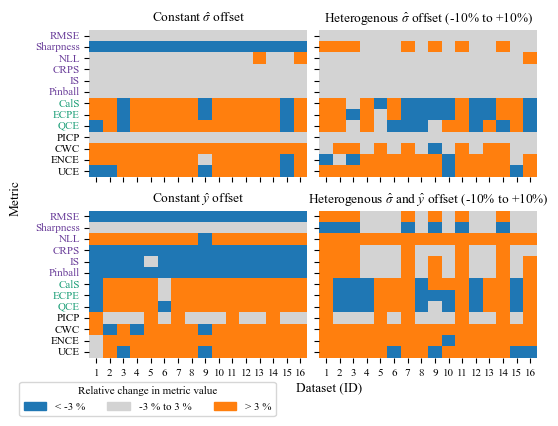

In [4]:
# Custom 3-color colormap
color_below = list(mcolors.TABLEAU_COLORS.values())[0]
color_between = "lightgrey"
color_above = list(mcolors.TABLEAU_COLORS.values())[1]
cmap = ListedColormap([color_below, color_between, color_above])

# Dictionary of dataframes for easy looping
dfs = {
    "Constant $\\hat{\\sigma}$ offset": relative_change_dict['lower_std'],
    "Heterogenous $\\hat{\\sigma}$ offset (-10% to +10%)": relative_change_dict['heterogeneous_std'],
    "Constant $\\hat{y}$ offset": relative_change_dict['lower_pred'],
    "Heterogenous $\\hat{\\sigma}$ and $\\hat{y}$ offset (-10% to +10%)": relative_change_dict['heterogeneous_both']
}

# Custom groupings (by index)
group_1 = ['RMSE', 'Sharpness', 'NLL', 'CRPS', 'IS', 'Pinball']       # Red
group_2 = ['CalS', 'ECPE', 'QCE']    # Green

# Color mapping for each group
group_colors = {
    'group_1': '#6a3d9a',  # deep purple
    'group_2': '#1b9e77',  # teal green
}
label_to_color = {}
for label in group_1:
    label_to_color[label] = group_colors['group_1']
for label in group_2:
    label_to_color[label] = group_colors['group_2']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(5.5,4), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each heatmap
for ax, (title, df) in zip(axes, dfs.items()):
    categorized = df.T.copy()
    categorized[df.T < - percent_threshold] = -1
    categorized[(df.T >= -percent_threshold) & (df.T <= percent_threshold)] = 0
    categorized[df.T > percent_threshold] = 1

    sns.heatmap(categorized, cmap=cmap, cbar=False, linewidths=0.0,
                xticklabels=True, yticklabels=True, ax=ax, vmin=-1, vmax=1)
    ax.set_xlabel('')
    ax.set_title(title)

    # Apply colors to x-axis tick labels
    for tick in ax.get_yticklabels():
        label_text = tick.get_text()
        tick.set_color(label_to_color.get(label_text, 'black'))  # default to black
# Create a shared legend
legend_patches = [
    mpatches.Patch(color=color_below, label=f"< {-percent_threshold} %"),
    mpatches.Patch(color=color_between, label=f"{-percent_threshold} % to {percent_threshold} %"),
    mpatches.Patch(color=color_above, label=f"> {percent_threshold} %")
]
fig.supxlabel('Dataset (ID)', x = 0.6)
fig.supylabel('Metric')
# Place the legend below all subplots
fig.legend(handles=legend_patches, title="Relative change in metric value", loc='lower center',
           ncol=3, bbox_to_anchor=(0.27, -0.06))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Leave space for the legend
plt.savefig("figures\\result_miscalibration_single.pdf", format="pdf", bbox_inches="tight")

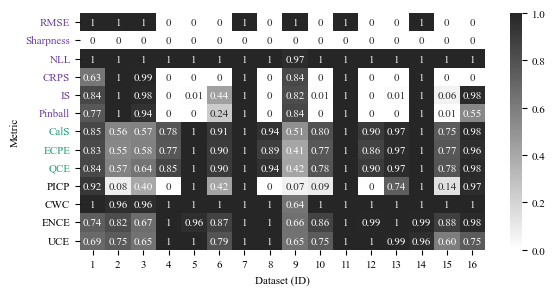

In [5]:
base_name = 'optimal'
target_cal_name = 'heterogeneous_both'
percent_threshold = 3

df = data.copy()
df = df[df['calibration'].isin([base_name]+[target_cal_name])]
df = df[list(new_column_names.values()) + ['name', 'calibration', 'n_run']]
# Plot over all Runs

multiindex = pd.MultiIndex.from_product([list(new_data_names.values()), [-1,0,1]], names=['names', 'cal'])
counter_df = pd.DataFrame(index=multiindex, columns=list(new_column_names.values()), data= 0)
 
for nrun in df['n_run'].unique():
    run_df = df[df['n_run'] == nrun]
    run_df = run_df.drop('n_run', axis=1)
    cal_groups = run_df.groupby('calibration', )
    base_group = cal_groups.get_group(base_name).drop('calibration', axis=1).set_index('name')
    target_group = cal_groups.get_group(target_cal_name).drop('calibration', axis=1).set_index('name')

    relative_change = create_relative_change_df(calibrated_data=target_group, noncal_data=base_group)
    categorized = relative_change.copy()
    categorized[relative_change < - percent_threshold] = -1
    categorized[(relative_change >= -percent_threshold) & (relative_change <= percent_threshold)] = 0
    categorized[relative_change > percent_threshold] = 1

    for row in categorized.index:
        for col in categorized.columns:
            val = int(categorized.loc[row, col])
            key = (row, val)
            
            if key in counter_df.index:
                current = counter_df.at[key, col] 
                counter_df.at[key, col] = 0 if pd.isna(current) else current + 1
            else:
                # Optional: warn or skip
                print(f"Skipping missing key: {key}")

correct_identification = counter_df.loc[pd.IndexSlice[:,1],:]/ len(df['n_run'].unique())
correct_identification.index = correct_identification.index.droplevel(1)

# Custom annotation formatting
def format_val(x):
    if np.isclose(x, 0.0):
        return "0"
    elif np.isclose(x, 1.0):
        return "1"
    else:
        return f"{x:.2f}"
formatted_annot = np.vectorize(format_val)(correct_identification)


fig, ax = plt.subplots(1, 1, figsize=(6,3))
sns.heatmap(correct_identification.T, annot=formatted_annot.T, fmt="", cmap=sns.color_palette("dark:white_r", as_cmap=True), ax = ax)

# Formating
# Apply colors to x-axis tick labels
for tick in ax.get_yticklabels():
    label_text = tick.get_text()
    tick.set_color(label_to_color.get(label_text, 'black'))  # default to black
ax.set_xlabel('Dataset (ID)')
ax.set_ylabel('Metric')

plt.tight_layout()
plt.savefig("figures\\result_miscalibration_stochastic.pdf", format="pdf", bbox_inches="tight")